<h2> Testing how close the normal distributions are </h2> 

The two means from the distribution $\mu_1$ $\mu_2$

In [2]:
import numpy as np
from scipy.stats import beta
from scipy.linalg import orthogonal_procrustes
import matplotlib.pyplot as plt

np.random.seed(45)


In [3]:
N=2

μ_1 = np.array([0.25,0.75])
μ_2 = np.array([0.75, 0.25])

μ_mat = np.stack((μ_1, μ_2), axis=1)

In [4]:
α = 2
β = 2
ρ_1, ρ_2 = beta.rvs(α, β, size=2)

exp_rho =   α / (α + β)

second_mom_rho = beta.moment(2, α, β)

second_mom_rho

0.3

We know the adjacency matrix - we can then use ACE to find the mean vectors (such as above). Then we need to estimate the mean for $X_1$. We have the different mean vectors and each vector has its own correction parameter, which contribute to the RDPG. So take a weighted average I guess?

To work out E[f($X_1$)] we assume each mean vector is equally likely to come up.

In [5]:
μ_1_outer = np.outer(μ_1, μ_1)
μ_2_outer = np.outer(μ_2, μ_2)

Δ = exp_rho**2 * (1 / 2) * (μ_1_outer + μ_2_outer)

Δ_inv = np.linalg.inv(Δ) 

In [6]:
exp_X1_inner_func = lambda x, ρ, μ:  (np.dot(x, ρ*μ) - (np.dot(x, ρ*μ)**2)) * np.outer(ρ*μ, ρ*μ)

N_ρ = 1000

ρ_samples_1 = beta.rvs(α, β, size=N_ρ)
ρ_samples_2 = beta.rvs(α, β, size=N_ρ)

def μ_1_integral_func(x):
    return (1 / N_ρ) * sum(exp_X1_inner_func(x, ρ, μ_1) for ρ in ρ_samples_1)

def μ_2_integral_func(x):
    return (1 / N_ρ) * sum(exp_X1_inner_func(x, ρ, μ_2) for ρ in ρ_samples_2)

def exp_X1_func_estimate(x):
    return 0.5 * (μ_1_integral_func(x) + μ_2_integral_func(x))


def covariance_estimate(x, num):
    return (Δ_inv @ exp_X1_func_estimate(x) @ Δ_inv) / num



We write to simulate an adjacency matrix and calculate the spectral embedding

In [7]:
# Simulate adjacency matrix

N_t = 1000
# Simulate N_t tuples of ρ and μ pairs

bern_params = [(beta.rvs(α, β, size=1), np.random.randint(0,2)) for _ in range(N_t)]

adj_mat = np.zeros((N_t, N_t))

for i in range(N_t):
    ρ_i, μ_i = bern_params[i][0], μ_mat[:, bern_params[i][1]]
    for j in range(i):
        ρ_j, μ_j = bern_params[j][0], μ_mat[:, bern_params[j][1]]

        adj_mat[i,j] = np.random.binomial(1, ρ_i * ρ_j * np.dot(μ_i, μ_j))

        adj_mat[j,i] = adj_mat[i,j]
    
    adj_mat[i,i] = 1


def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

check_symmetric(adj_mat)

/var/folders/c3/91bqt9g14t73pxvtc2mr0xg00000gn/T/ipykernel_1065/181328482.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  adj_mat[i,j] = np.random.binomial(1, ρ_i * ρ_j * np.dot(μ_i, μ_j))


True

In [8]:
eigvals, eigvecs = np.linalg.eig(adj_mat)

In [9]:
# Get eigen values sorted by magnitude
sorted_indexes = np.argsort(np.abs(eigvals))[::-1]
eigvals = eigvals[sorted_indexes]
eigvecs = eigvecs[:,sorted_indexes]

Take top eigenvectors to form the ASE estimate, and take absolute square root of eigenvectors

In [10]:
embedding_dim = len(μ_1)
eigvecs_trunc = eigvecs[:,:2]
eigvals_trunc = np.diag(np.sqrt(np.abs(eigvals[:2])))
spectral_emb = eigvecs_trunc @ eigvals_trunc

Use orthogonal Prosuctes solution to find best fitting orthogonal matrix

In [11]:
# Form true mean vectors from bernparams
true_means = np.zeros((N_t, 2))

for i in range(N_t):
    ρ_i, μ_i = bern_params[i][0], μ_mat[:, bern_params[i][1]]
    true_means[i, :] =  ρ_i * μ_i

best_orthog_mat = orthogonal_procrustes(spectral_emb, true_means)

In [12]:
spectral_emb = spectral_emb @ best_orthog_mat[0]

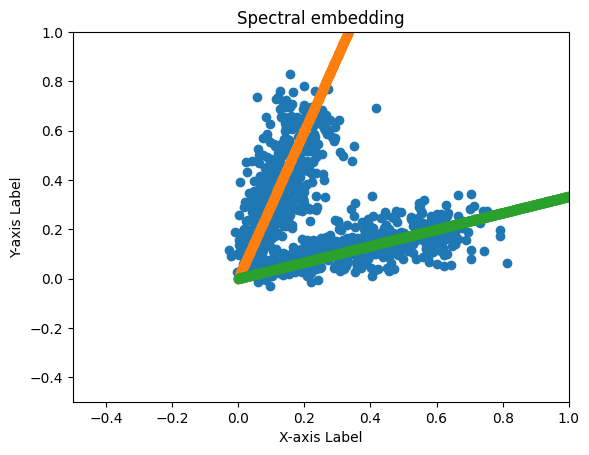

In [13]:

plt.scatter(spectral_emb[:,0], spectral_emb[:,1])
xrange = np.linspace(0, 1, 1000)

plt.scatter(xrange, 3*xrange)

plt.scatter(xrange, xrange / 3)

plt.xlim(-0.5, 1)
plt.ylim(-0.5, 1)

plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Spectral embedding')
plt.show()

We know that in the limit our samples ACE samples follow a multivariate normal distribution. We find the distribution of the x from the oint distribution (x,ρ)

In [14]:
# We sample 100 values from each mean group

# group 1
group_1_samples = []
ρ_1_samples = []

group_mean = μ_1
for i in range(N_t):
    # sample the ρ's
    ρ = beta.rvs(α, β, size=1)
    group_1_samples.append(np.random.multivariate_normal(ρ*group_mean,
                        covariance_estimate(ρ*group_mean, N_t)))

    ρ_1_samples.append(ρ)


group_1_samples = np.array(group_1_samples)

ρ_1_samples = np.array(ρ_1_samples)
    

# group 2

group_2_samples = []
ρ_2_samples = []

group_mean = μ_2
for i in range(N_t):
    # sample the ρ's
    ρ = beta.rvs(α, β, size=1)

    group_2_samples.append(np.random.multivariate_normal(ρ*group_mean,
                        covariance_estimate(ρ*group_mean, N_t)))
    
    ρ_2_samples.append(ρ)

group_2_samples = np.array(group_2_samples)

ρ_2_samples = np.array(ρ_2_samples)

all_hat_samples = np.concatenate((group_1_samples, group_2_samples), axis=0)

all_hat_ρ = np.concatenate((ρ_1_samples,ρ_2_samples), axis=0)




In [15]:
true_hat_means = np.zeros((2*N_t, 2))

for i in range(N_t):
    true_hat_means[i, :] =  ρ_1_samples[i] * μ_1

for i in range(N_t,2*N_t):
    true_hat_means[i, :] =  all_hat_ρ[i] * μ_2

In [16]:
best_orthog_mat_hat = orthogonal_procrustes(all_hat_samples, true_hat_means)

In [17]:
all_hat_samples = all_hat_samples @ best_orthog_mat_hat[0]

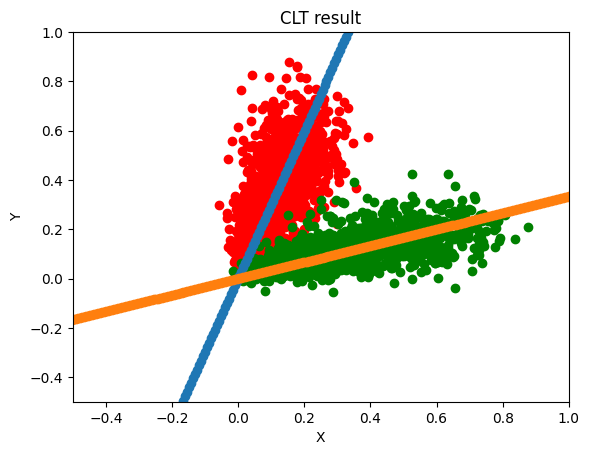

In [18]:
#plt.scatter(all_hat_samples[:,0], all_hat_samples[:,1])

plt.scatter(all_hat_samples[:N_t,0], all_hat_samples[:N_t,1], color='red')
plt.scatter(all_hat_samples[N_t:,0], all_hat_samples[N_t:,1], color='green')


xrange = np.linspace(-3, 3, 1000)

plt.scatter(xrange, 3*xrange)

plt.scatter(xrange, xrange / 3)

plt.xlim(-0.5, 1)
plt.ylim(-0.5, 1)



plt.xlabel('X')
plt.ylabel('Y')
plt.title('CLT result')
plt.show()

(-0.5, 1.0)

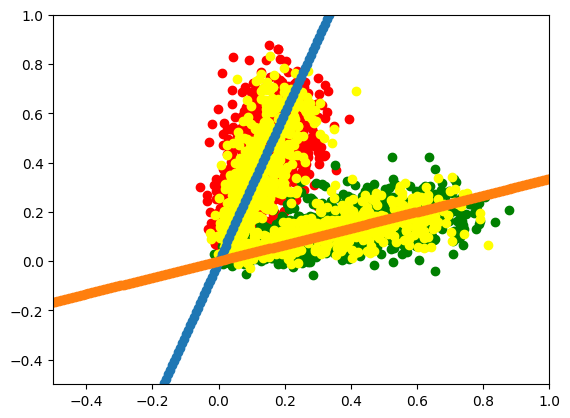

In [19]:
#Comparing ASE embedding to the respective CLTT result

plt.scatter(all_hat_samples[:N_t,0], all_hat_samples[:N_t,1], color='red')
plt.scatter(all_hat_samples[N_t:,0], all_hat_samples[N_t:,1], color='green')

plt.scatter(spectral_emb[:,0], spectral_emb[:,1], color='yellow')



xrange = np.linspace(-3, 3, 1000)

plt.scatter(xrange, 3*xrange)

plt.scatter(xrange, xrange / 3)

plt.xlim(-0.5, 1)
plt.ylim(-0.5, 1)

Know we look at the $\tilde{x}$ samples - we assume they come from a multivariate normal distribution with mean 0 and respective variance and see how the samples line up 

In [20]:
# Variance

# A matrix
exp_A_matrix = lambda x, ρ, μ:  (np.dot(x, ρ*μ)) * np.outer(ρ*μ, ρ*μ)

exp_B_matrix = lambda x, ρ, μ:  (np.dot(x, ρ*μ)**2) * np.outer(ρ*μ, ρ*μ)

N_ρ = 1000

ρ_samples_1 = beta.rvs(α, β, size=N_ρ)
ρ_samples_2 = beta.rvs(α, β, size=N_ρ)

def μ_1_integral_func(x, matrix_func):
    return (1 / N_ρ) * sum(matrix_func(x, ρ, μ_1) for ρ in ρ_samples_1)

def μ_2_integral_func(x, matrix_func):
    return (1 / N_ρ) * sum(matrix_func(x, ρ, μ_2) for ρ in ρ_samples_2)

def exp_matrix_innner_func_estimate(x, matrix_func):
    return 0.5 * (μ_1_integral_func(x, matrix_func) + μ_2_integral_func(x, matrix_func))


def matrix_estimate(x, matrix_func, num):
    return (Δ_inv @ exp_matrix_innner_func_estimate(x, matrix_func) @ Δ_inv) / num






In [21]:
# group 1
A_dash_1 = matrix_estimate(μ_1, exp_A_matrix, N_t)
B_dash_1 = matrix_estimate(μ_1, exp_B_matrix, N_t)


mvn_cov_1 = (A_dash_1 * exp_rho) - (B_dash_1 * second_mom_rho)

A_dash_2 = matrix_estimate(μ_2, exp_A_matrix, N_t)
B_dash_2 = matrix_estimate(μ_2, exp_B_matrix, N_t)

mvn_cov_2 = (A_dash_2 * exp_rho) - (B_dash_2 * second_mom_rho)

In [22]:
mvn_cov_1

array([[ 0.00264311, -0.00187475],
       [-0.00187475,  0.00360605]])

In [23]:
mvn_cov_2

array([[ 0.0035566 , -0.00186911],
       [-0.00186911,  0.00267376]])

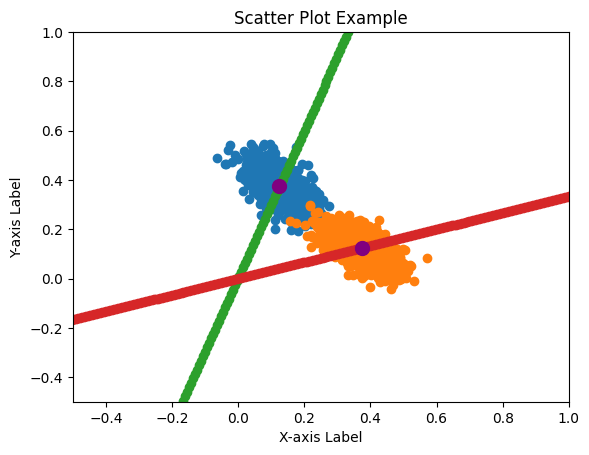

In [24]:
mvn_1_assumption_samples = [np.random.multivariate_normal(0.5 * μ_1, mvn_cov_1) for _ in range(1000)]

#mvn_1_assumption_samples = np.random.multivariate_normal(np.array([0.0,0.0]), mvn_cov_1, size=(1000,2)) + [1.0, 0.0]

mvn_2_assumption_samples = [np.random.multivariate_normal((0.5 * μ_2), mvn_cov_2) for _ in range(1000)]

mvn1_x = [mvn_sample[0] for mvn_sample in mvn_1_assumption_samples]
mvn1_y = [mvn_sample[1] for mvn_sample in mvn_1_assumption_samples]

mvn2_x = [mvn_sample[0] for mvn_sample in mvn_2_assumption_samples]
mvn2_y = [mvn_sample[1] for mvn_sample in mvn_2_assumption_samples]


plt.scatter(mvn1_x, mvn1_y)
plt.scatter(mvn2_x, mvn2_y)
plt.scatter(xrange, 3*xrange)
plt.scatter(xrange, xrange / 3)
plt.scatter(*(0.5 * μ_1), color='purple', s=100)
plt.scatter(*(0.5 * μ_2), color='purple', s=100)

plt.xlim(-0.5, 1)
plt.ylim(-0.5, 1)

plt.plot(0.25, 0.75)
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Scatter Plot Example')
plt.show()





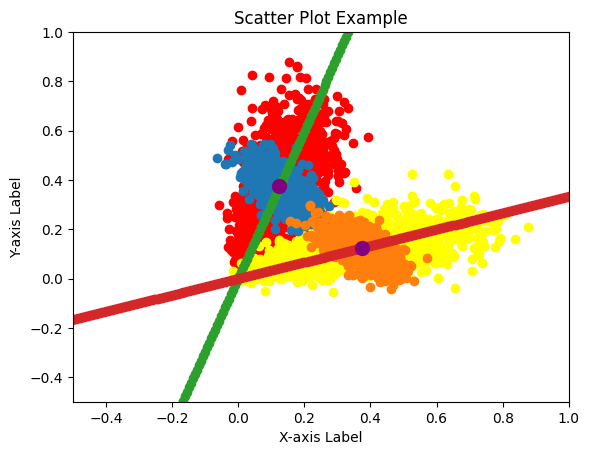

In [25]:
plt.scatter(all_hat_samples[:N_t,0], all_hat_samples[:N_t,1], color='red')
plt.scatter(all_hat_samples[N_t:,0], all_hat_samples[N_t:,1], color='yellow')
plt.scatter(mvn1_x, mvn1_y)
plt.scatter(mvn2_x, mvn2_y)
plt.scatter(xrange, 3*xrange)
plt.scatter(xrange, xrange / 3)
plt.scatter(*(0.5 * μ_1), color='purple', s=100)
plt.scatter(*(0.5 * μ_2), color='purple', s=100)

# plt.scatter(mvn_2_assumption_samples[:,0], mvn_2_assumption_samples[:,1])

plt.xlim(-0.5, 1)
plt.ylim(-0.5, 1)

plt.plot(0.25, 0.75)

plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Scatter Plot Example')
plt.show()

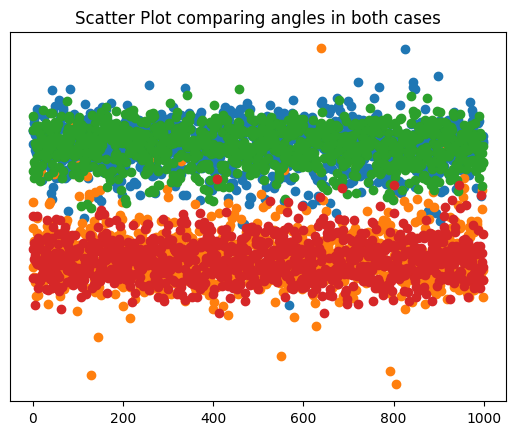

In [26]:
# Look at the angles of each of them after spherical transformation


# Creating a 1D scatter plot
# The y-values are set to 0, as we are only interested in the distribution along the x-axis

#get rid of samples close to axis
# mask_group_1 = all_hat_samples[:N_t,1]**2 + all_hat_samples[:N_t,0]**2 > 0.08
# mask_group_2 = all_hat_samples[N_t:,1]**2 + all_hat_samples[N_t:,0]**2 > 0.08

sph_trans_clt_group_1 = np.arctan2(all_hat_samples[:N_t,1], all_hat_samples[:N_t,0]) 
sph_trans_clt_group_2 = np.arctan2(all_hat_samples[N_t:,1], all_hat_samples[N_t:,0])

sph_trans_mvn_group_1 = np.arctan2(mvn1_y, mvn1_x) 
sph_trans_mvn_group_2 = np.arctan2(mvn2_y, mvn2_x) 





# plt.scatter(np.arctan2(all_hat_samples[:N_t,1], all_hat_samples[:N_t,0])[mask_group_1] , range(len()), c='blue', edgecolors='none', s=50)
# plt.scatter(np.arctan2(all_hat_samples[N_t:,1], all_hat_samples[N_t:,0])[mask_group_2] , np.zeros_like(all_hat_samples[N_t:,1])[mask_group_2], c='red', edgecolors='none', s=50)

plt.scatter(range(len(sph_trans_clt_group_1)), sph_trans_clt_group_1)
plt.scatter(range(len(sph_trans_clt_group_2)), sph_trans_clt_group_2)

plt.scatter(range(len(sph_trans_mvn_group_1)), sph_trans_mvn_group_1)
plt.scatter(range(len(sph_trans_mvn_group_2)), sph_trans_mvn_group_2)


# Optional: Adding labels and title for clarity
plt.title('Scatter Plot comparing angles in both cases')
plt.yticks([])  # Hides y-ticks as they are not relevant in a 1D scatter plot

# Show the plot
plt.show()



We know look at what happens when we make te assumption $\Sigma^*$ (i.e. dividing by $\bar{\rho}$) and seeing how that compares to the actual distribution

In [27]:
exp_X1_inner_func_assump = lambda x, ρ, μ:  ((np.dot(x, ρ*μ) / exp_rho) - (np.dot(x, ρ*μ)**2)) * np.outer(ρ*μ, ρ*μ)

N_ρ = 1000

ρ_samples_1 = beta.rvs(α, β, size=N_ρ)
ρ_samples_2 = beta.rvs(α, β, size=N_ρ)

def μ_1_integral_func(μ):
    return (1 / N_ρ) * sum(exp_X1_inner_func_assump(μ, ρ, μ_1) for ρ in ρ_samples_1)

def μ_2_integral_func(μ):
    return (1 / N_ρ) * sum(exp_X1_inner_func_assump(μ, ρ, μ_2) for ρ in ρ_samples_2)

def exp_X1_func_estimate_assump(μ):
    return 0.5 * (μ_1_integral_func(μ) + μ_2_integral_func(μ))


def covariance_estimate_assump(ρ, μ, num):
    return ρ**2 * (Δ_inv @ exp_X1_func_estimate_assump(μ) @ Δ_inv) / num

In [28]:
# group 1
group_1_samples_assump = []
ρ_1_samples_assump = []

group_mean = μ_1
for i in range(N_t):
    # sample the ρ's
    ρ = beta.rvs(α, β, size=1)
    group_1_samples_assump.append(np.random.multivariate_normal(ρ*group_mean,
                        covariance_estimate_assump(ρ, group_mean, N_t)))

    ρ_1_samples_assump.append(ρ)


group_1_samples_assump = np.array(group_1_samples_assump)
ρ_1_samples_assump = np.array(ρ_1_samples)
    

# group 2

group_2_samples_assump = []
ρ_2_samples_assump = []

group_mean = μ_2
for i in range(N_t):
    # sample the ρ's
    ρ = beta.rvs(α, β, size=1)

    group_2_samples_assump.append(np.random.multivariate_normal(ρ*group_mean,
                        covariance_estimate_assump(ρ, group_mean, N_t)))
    
    ρ_2_samples_assump.append(ρ)

group_2_samples_assump = np.array(group_2_samples_assump)

ρ_2_samples_assump = np.array(ρ_2_samples_assump)

all_hat_samples_assump = np.concatenate((group_1_samples_assump, group_2_samples_assump), axis=0)

all_hat_ρ_assump = np.concatenate((ρ_1_samples_assump,ρ_2_samples_assump), axis=0)

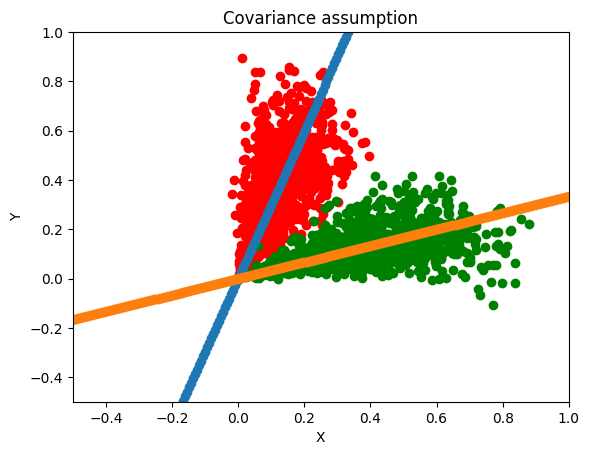

In [29]:
true_hat_means_assump = np.zeros((2*N_t, 2))

for i in range(N_t):
    true_hat_means_assump[i, :] =  ρ_1_samples_assump[i] * μ_1

for i in range(N_t,2*N_t):
    true_hat_means_assump[i, :] =  all_hat_ρ_assump[i] * μ_2


best_orthog_mat_hat_assump = orthogonal_procrustes(all_hat_samples_assump, true_hat_means_assump)

all_hat_samples_assump = all_hat_samples_assump @ best_orthog_mat_hat_assump[0]

plt.scatter(all_hat_samples_assump[:N_t,0], all_hat_samples_assump[:N_t,1], color='red')
plt.scatter(all_hat_samples_assump[N_t:,0], all_hat_samples_assump[N_t:,1], color='green')


xrange = np.linspace(-3, 3, 1000)

plt.scatter(xrange, 3*xrange)

plt.scatter(xrange, xrange / 3)

plt.xlim(-0.5, 1)
plt.ylim(-0.5, 1)



plt.xlabel('X')
plt.ylabel('Y')
plt.title('Covariance assumption')
plt.show()



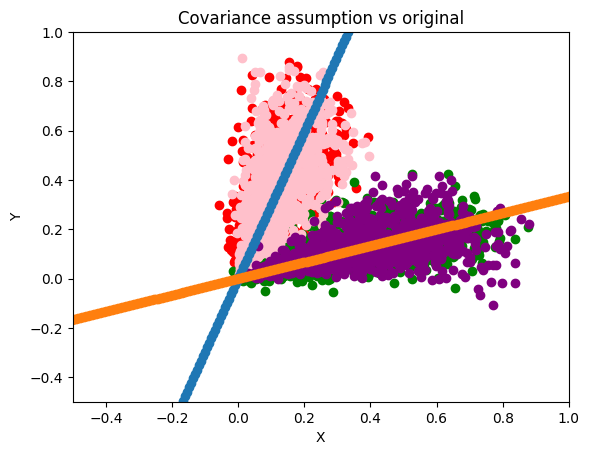

In [30]:
plt.scatter(all_hat_samples[:N_t,0], all_hat_samples[:N_t,1], color='red')
plt.scatter(all_hat_samples[N_t:,0], all_hat_samples[N_t:,1], color='green')

plt.scatter(all_hat_samples_assump[:N_t,0], all_hat_samples_assump[:N_t,1], color='pink')
plt.scatter(all_hat_samples_assump[N_t:,0], all_hat_samples_assump[N_t:,1], color='purple')


xrange = np.linspace(-3, 3, 1000)

plt.scatter(xrange, 3*xrange)

plt.scatter(xrange, xrange / 3)

plt.xlim(-0.5, 1)
plt.ylim(-0.5, 1)



plt.xlabel('X')
plt.ylabel('Y')
plt.title('Covariance assumption vs original')
plt.show()